### Imports

In [100]:
import os
import yaml
import sys
# Set project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Load config.yaml

In [101]:
#get config file
config_path = os.path.join(project_root, "config.yaml")

def load_config():
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"ERROR: config.yaml not found at {config_path}")
    else:
        with open(config_path, "r") as file:
            config = yaml.safe_load(file)
    return config

# Test load
config = load_config()
print("Config loaded successfully!")

Config loaded successfully!


### Import `aggregated_full.csv` Dataset

In [102]:
READ_FOLDER_PATH = '../data/processed/'

df = pd.read_csv(READ_FOLDER_PATH+'aggregated_full.csv')

print(df.shape[0])
pd.set_option("display.max_colwidth", None) 
df

9074


,id_odsp,date,season,league,country,home_team,away_team,odd_h,odd_d,odd_a,...,total_fouls_75_80,odds_ratio,shot_to_corner_ratio_pre_80,team_aggression_score_pre_80,home_urgency_to_attack,away_urgency_to_attack,home_momentum_to_attack,away_momentum_to_attack,attack_intensity,defensive_pressure
0,UFot0hit/,2011-08-05,2012,D1,germany,Borussia Dortmund,Hamburg SV,1.56,4.41,7.42,...,0,0.210,1.692,1.273,0.000,0.067,0.000,0.067,0,-2
1,Aw5DflLH/,2011-08-06,2012,D1,germany,FC Augsburg,SC Freiburg,2.36,3.60,3.40,...,1,0.694,2.429,2.294,0.424,0.000,-0.424,-0.000,0,-3
2,CzPV312a/,2011-08-06,2012,F1,france,Paris Saint-Germain,Lorient,1.55,4.50,9.40,...,0,0.165,2.222,1.250,0.645,0.000,1.935,-0.000,3,0
3,GUOdmtII/,2011-08-06,2012,F1,france,Caen,Valenciennes,2.50,3.40,3.45,...,1,0.725,1.900,1.000,0.000,0.290,0.000,0.000,0,-2
4,M7PhlM2C/,2011-08-06,2012,F1,france,Brest,Evian Thonon Gaillard,2.29,3.25,3.85,...,0,0.595,2.000,0.767,0.627,0.373,2.508,0.000,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9069,vJy048Er/,2017-01-22,2017,I1,italy,Empoli,Udinese,2.90,3.18,2.96,...,2,0.980,1.250,3.800,0.505,0.495,-0.505,0.000,0,0
9070,xAkY8l6R/,2017-01-22,2017,I1,italy,Genoa,Crotone,1.97,4.35,8.00,...,1,0.246,2.100,1.143,0.802,0.198,-0.802,-0.396,0,0
9071,xSU9scI9/,2017-01-22,2017,E0,england,Chelsea,Hull,1.19,8.50,20.00,...,0,0.060,1.000,1.533,0.000,0.050,0.000,0.050,1,-2
9072,xY7uZwOI/,2017-01-22,2017,F1,france,AS Monaco,Lorient,1.32,6.24,11.50,...,0,0.115,2.375,1.000,0.000,0.000,0.000,0.000,0,0


### Select features from config

In [103]:
context_features = config.get("features",{}).get("context_features",[])
selected_features = config.get("features",{}).get("selected_features",[])
constructed_features = config.get("features",{}).get("constructed_features",[])
target_variables =config.get("features",{}).get("target_variables",[])

if constructed_features is None:
    constructed_features = []

selected_columns = context_features + selected_features + constructed_features + target_variables
df = df[selected_columns]

#Drop NaN and inf rows:
df_selected = df.copy()
df_selected.loc[:, :] = df.replace([np.inf, -np.inf], np.nan)
df_selected = df_selected.dropna()

### Plot correlation heatmap (for selected features)

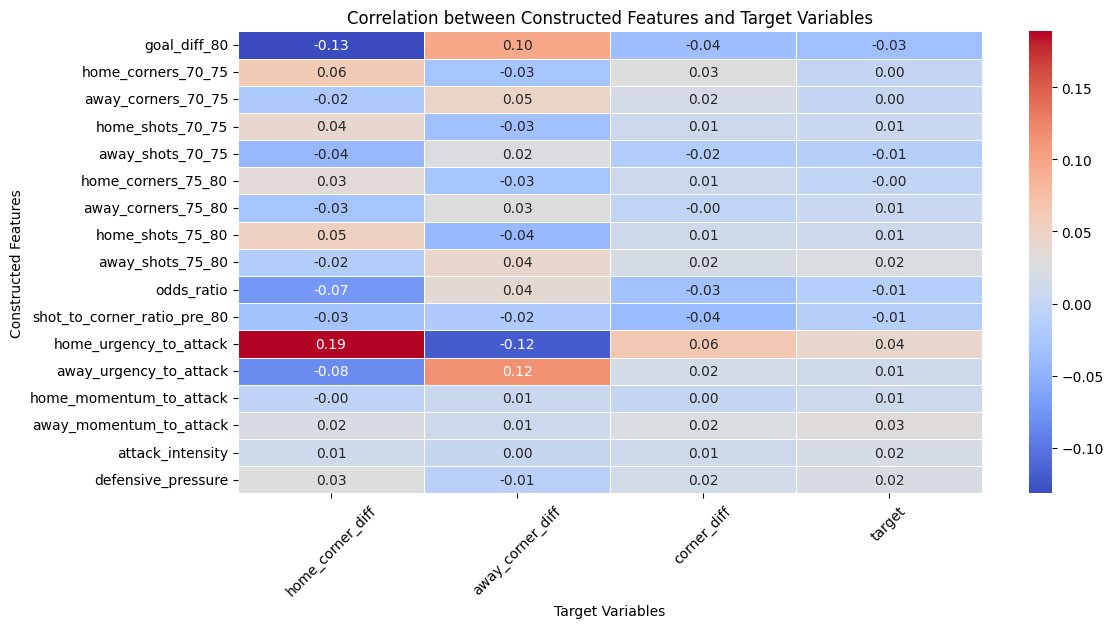

In [104]:
#Corelation matrix:
correlation_matrix = df_selected[selected_features + constructed_features + target_variables].corr()
correlation_with_target = correlation_matrix[target_variables].drop(target_variables, axis=0)

# Plot correlation heatmap:
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_with_target, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel("Target Variables")
plt.ylabel("Constructed Features")
plt.title("Correlation between Constructed Features and Target Variables")
plt.show()

## RF Model Fit (Train, Validate and Test)

- Split data to exclude the last 500 rows for testing
- Split further to: 80% train and 20% validation

In [105]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, make_scorer, precision_score

#Only train on selected and constructed features
X=df_selected[selected_features + constructed_features]
y=df_selected["target"]

#Split data to exclude the last 500 rows for testing
train_data = df_selected.iloc[:-500]
test_data = df_selected.iloc[-500:]

# Split data -> train & validation
X_train, X_val, y_train, y_val = train_test_split(
    train_data[selected_features + constructed_features],
    train_data["target"],
    test_size=0.2,
    random_state=42,
    stratify=train_data["target"]
)

#Load hyperparameters settings from config yaml...
classification_config = config['model']['classification']
do_grid_search = classification_config['grid_search']
rf_hyperparameters = classification_config['hyperparameters'].get('random_forest', {})

# Init RF Classifier with inputted hyperparameters
model = RandomForestClassifier(**rf_hyperparameters, random_state=42, class_weight="balanced")

if do_grid_search:
    #Perform GridSearch:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10,20],
        'min_samples_split': [2, 5,10],
        'min_samples_leaf': [1,2,4],
        'bootstrap':[True, False]
    }  

    #Score by precision 
    precision_scorer = make_scorer(precision_score, average="micro")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=precision_scorer, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Precision Score:", grid_search.best_score_)

    #Use best_estimator for predictions
    best_model = grid_search.best_estimator_
    best_model
else:
    #Otherwise... use specified hyperparameters for RF model
    model.fit(X_train, y_train)
    best_model = model

# Predict on the validation set
y_pred_val = best_model.predict_proba(X_val)[:, 1]

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': best_model.feature_names_in_,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n### Feature Importance:\n")
print(feature_importances.to_string(index=False))


### Feature Importance:

                    Feature  Importance
                 odds_ratio    0.169633
shot_to_corner_ratio_pre_80    0.162847
     away_urgency_to_attack    0.099562
     home_urgency_to_attack    0.080990
    away_momentum_to_attack    0.073557
         defensive_pressure    0.068805
    home_momentum_to_attack    0.065341
           home_shots_70_75    0.038610
           home_shots_75_80    0.035534
           away_shots_70_75    0.034061
               goal_diff_80    0.031674
           away_shots_75_80    0.031023
           attack_intensity    0.025742
         home_corners_70_75    0.022075
         home_corners_75_80    0.021165
         away_corners_75_80    0.019842
         away_corners_70_75    0.019538


## Precision-Recall Optimisation via Threshold Adjustment

- Our aim is to increase Precision-Recall (more importantly precision), since we want to increase the likelihood of winning a 1+ corners at 80min bet -> prediciting the number of 1's correctly as important, i.e. when we do place a bet, we make sure we have a high chance of winning.
- Therefore, I performed threshold adjustament to try and maximise precision (but ensure recall is at least 10% to avoid precision=1)

In [106]:
from sklearn.metrics import precision_score, recall_score

#--- Threshold Maximisation ---
thresholds = np.linspace(0.5, 0.95, 20) #test thresholds from 0.5 to 0.95
results = []   
for t in thresholds:
    y_pred_t =(y_pred_val>=t).astype(int)
    precision_t= precision_score(y_val, y_pred_t)  
    recall_t= recall_score(y_val, y_pred_t)
    
    if recall_t>=0.1: #only take results where recall >= 0.1
        results.append((t, precision_t, recall_t))
 
#results as table
print("\n### Precision-Recall Tradeoff at Different Thresholds ###\n") 
print(f"{'Threshold':<12}{'Precision':<12}{'Recall':<12}") 
print("-"*36)  
for t, p, r in results:
    print(f"{t:<12.2f}{p:<12.4f}{r:<12.4f}")

##best threshold
best_threshold = max(results, key=lambda x: x[1])
optimal_threshold = round(best_threshold[0],3)
print("\n### Recommended Threshold for Maximum Precision ###")
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Expected Precision: {best_threshold[1]:.4f}")
print(f"Expected Recall: {best_threshold[2]:.4f}")

# --- Model Evaluation ---
y_pred_threshold =(y_pred_val >= optimal_threshold).astype(int)

print(f"\n### Classification Report (threshold={optimal_threshold}):\n") 
print(classification_report(y_val, y_pred_threshold))


### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.7606      0.9800      
0.52        0.7602      0.9685      
0.55        0.7594      0.9570      
0.57        0.7578      0.9340      
0.59        0.7592      0.9194      
0.62        0.7590      0.8918      
0.64        0.7573      0.8596      
0.67        0.7567      0.8212      
0.69        0.7579      0.7759      
0.71        0.7612      0.7068      
0.74        0.7679      0.6324      
0.76        0.7730      0.5541      
0.78        0.7637      0.4712      
0.81        0.7670      0.3638      
0.83        0.7802      0.2724      
0.86        0.7945      0.1781      
0.88        0.8324      0.1182      

### Recommended Threshold for Maximum Precision ###
Optimal Threshold: 0.88
Expected Precision: 0.8324
Expected Recall: 0.1182

### Classification Report (threshold=0.879):

              precision    recall  f1-score   support

       

## Testing RF Classifier on backtesting set

- Test on final 500 rows (used to generate input csv for backtesting)
- Plot scatter graph to visualise our spread of predictions & how the threshold binarises them.


### Prediction on last 500 rows: ###
              precision    recall  f1-score   support

           0       0.25      0.90      0.39       118
           1       0.83      0.15      0.26       382

    accuracy                           0.33       500
   macro avg       0.54      0.53      0.32       500
weighted avg       0.69      0.33      0.29       500



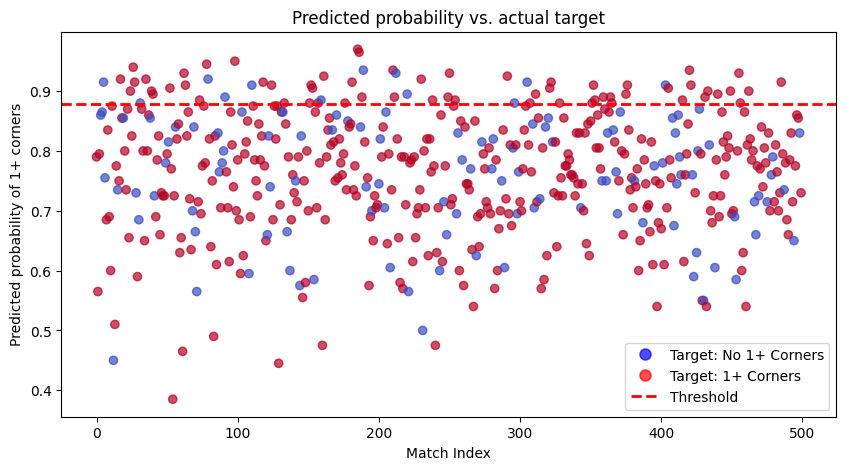

In [107]:
# --- Test on Last 500 Rows ---
X_test_final= test_data[selected_features+constructed_features]
y_test_final =test_data["target"]

# Predict on the final test data (last 500 rows)
y_probs_final =model.predict_proba(X_test_final)[:, 1]
y_pred_final=(y_probs_final >=optimal_threshold).astype(int)

#Evaluate on the last 500 rows (final simulation)
print("\n### Prediction on last 500 rows: ###")
print(classification_report(y_test_final, y_pred_final))

# Scatter plot: target vs predicted probabilities
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_probs_final)), y_probs_final,c=y_test_final,cmap='coolwarm',alpha=0.7,label='Predicted Probability')
plt.axhline(optimal_threshold, color='red', linestyle='dashed',linewidth=2,label=f'Threshold = {optimal_threshold:.2f}')
import matplotlib.lines as mlines
class_0 =mlines.Line2D([], [],color='blue',marker='o',linestyle='None', markersize=8, alpha=0.7, label='Target: No 1+ Corners')
class_1=mlines.Line2D([], [],color='red', marker='o',linestyle='None',markersize=8,alpha=0.7, label='Target: 1+ Corners')
plt.xlabel('Match Index')
plt.ylabel('Predicted probability of 1+ corners')
plt.title('Predicted probability vs. actual target')
plt.legend(handles=[class_0, class_1,plt.Line2D([], [],color='red',linestyle='dashed',linewidth=2,label='Threshold')])
plt.show()

## Feed data into CSV to be used for simulation
- Saves a csv with match_id, odds, model predictions, and actual results

In [108]:
results_df = pd.DataFrame({
    'kaggle_id': test_data['id_odsp'],
    'model_predicted_binary': y_pred_final,
    'actual_result': y_test_final
})
data_file = "../classification_predictions.csv"
results_df.to_csv(data_file, index=False)
print(f"Results saved to {data_file}")

Results saved to ../classification_predictions.csv
